In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Thiết lập các thông số
batch_size = 32 #100
image_size = 28
num_channels = 1
latent_size = 100  # Kích thước của vector nhiễu đầu vào cho GAN

# Tải và chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fashion-MNIST dataset từ torchvision
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 18698696.62it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 323233.52it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5422097.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 919837.99it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, image_size):
        super(Generator, self).__init__()
        self.image_size = image_size

        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, num_channels * image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), self.image_size, self.image_size, num_channels)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_channels * image_size * image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [ ]:
class cGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(cGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, z):
        gen_imgs = self.generator(z)
        validity = self.discriminator(gen_imgs)
        return validity, gen_imgs


In [ ]:
# Khởi tạo mô hình, bộ tối ưu và hàm loss
generator = Generator(latent_size, num_channels, image_size)
discriminator = Discriminator(num_channels, image_size)
cgan = cGAN(generator, discriminator)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()

# Huấn luyện
num_epochs = 10

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # Huấn luyện Discriminator
        optimizer_D.zero_grad()

        z = torch.randn(imgs.size(0), latent_size)
        gen_imgs = generator(z)

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Huấn luyện Generator
        optimizer_G.zero_grad()

        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )


[Epoch 0/10] [Batch 0/1875] [D loss: 0.6997385025024414] [G loss: 0.6828347444534302]
[Epoch 0/10] [Batch 100/1875] [D loss: 0.32996803522109985] [G loss: 3.225648880004883]
[Epoch 0/10] [Batch 200/1875] [D loss: 0.6210465431213379] [G loss: 2.058178663253784]
[Epoch 0/10] [Batch 300/1875] [D loss: 0.4239850640296936] [G loss: 2.4694926738739014]
[Epoch 0/10] [Batch 400/1875] [D loss: 0.5436300039291382] [G loss: 2.7170779705047607]
[Epoch 0/10] [Batch 500/1875] [D loss: 0.4350687861442566] [G loss: 1.9119446277618408]
[Epoch 0/10] [Batch 600/1875] [D loss: 0.6916693449020386] [G loss: 2.5703091621398926]
[Epoch 0/10] [Batch 700/1875] [D loss: 0.4044649600982666] [G loss: 2.115946054458618]
[Epoch 0/10] [Batch 800/1875] [D loss: 0.49662554264068604] [G loss: 1.8209400177001953]
[Epoch 0/10] [Batch 900/1875] [D loss: 0.5750242471694946] [G loss: 0.9466201663017273]
[Epoch 0/10] [Batch 1000/1875] [D loss: 0.5600942373275757] [G loss: 1.341071605682373]
[Epoch 0/10] [Batch 1100/1875] [D l

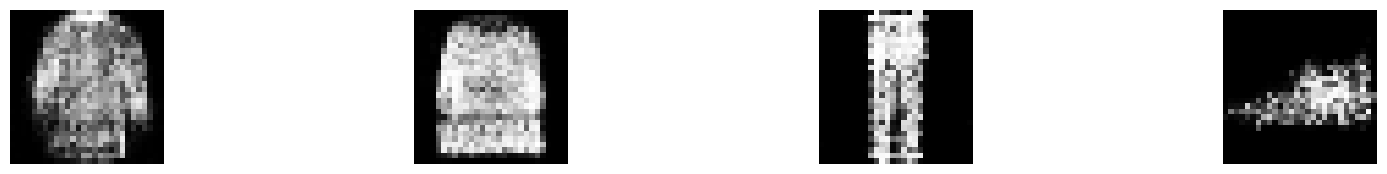

In [ ]:
# Tạo ảnh mới từ generator
n_images = 4
z = torch.randn(n_images, latent_size)
generated_images = generator(z)

# Hiển thị ảnh
fig, axs = plt.subplots(1, n_images, figsize=(20, 2))

for i in range(n_images):
    axs[i].imshow(generated_images[i].detach().view(image_size, image_size), cmap='gray')
    axs[i].axis('off')

plt.show()
